# 01b02 RNA Velocity Data

In [ ]:
# default_exp datasets

!nbdev_build_lib

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


RNA velocity is a high-dimensional vector that predicts the future state of individual cells on a timescale of hours. Authors of RNA Velocity expect it to greatly aid the analysis of developmental lineages and cellular dynamics, particularly in humans.

In this notebook, we have single-cell datasets with RNA velocity information. Functions return 2 $n \times d$ torch tensors and a list. The first tensor contains information of $n$ cells with $d$ features and the second tensor holds the vectors associated with the aforementioned $n$ cells in the same $d$ directions. The list contains the ground truth cell type labels of each of the $n$ cells.

## scvelo Dataset Loaders

In [ ]:
import scvelo as scv
import numpy as np

def add_labels(clusters):
    cluster_set = set(clusters)
    d = {cluster: i for i, cluster in enumerate(cluster_set)}
    labels = np.array([d[cluster] for cluster in clusters])
        
    return labels

# call this 
def process_rnavelo_dataset(adata):
    #preprocess data and calculate rna velocity
    scv.pp.filter_and_normalize(adata)
    scv.pp.moments(adata)
    scv.tl.velocity(adata, mode='stochastic')

## scvelo Pancreas Dataset

### Functions to Return RNA Velocity Dataset

In [ ]:
#export

def pancreas_rnavelo_load_data():
    # load data
    adata = scv.datasets.pancreas()
    
    #preprocess data and calculate rna velocity
    scv.pp.filter_and_normalize(adata)
    scv.pp.moments(adata)
    scv.tl.velocity(adata, mode='stochastic')
    
    return adata

def pancreas_rnavelo():
    # load preprocessed data
    adata = pancreas_rnavelo_load_data()
    
    # set datapoints (X) and flows
    X = torch.tensor(adata.X.todense())
    flows = torch.tensor(adata.layers["velocity"])
    labels = add_labels(adata.obs["clusters"])
        
    return X, flows, labels

def pancreas_rnavelo_pcs():
    adata = pancreas_rnavelo_load_data()
    
    # calculate velocity pca (50 dimensions) and display pca plot (2 dimensions)
    scv.tl.velocity_graph(adata)
    scv.pl.velocity_embedding_stream(adata, basis='pca')
    
    X = torch.tensor(adata.obsm["X_pca"])
    flows = torch.tensor(adata.obsm["velocity_pca"])
    labels = add_labels(adata.obs["clusters"])
    n_pcs = X.shape[1]
    
    return X, flows, labels, n_pcs

### Function Checks

In [ ]:
X, flows, labels = pancreas_rnavelo()

Normalized count data: X, spliced, unspliced.
Logarithmized X.
computing neighbors
    finished (0:00:01) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities


KeyboardInterrupt: 

Normalized count data: X, spliced, unspliced.
Logarithmized X.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:10) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:16) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/8 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:51) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:01) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)


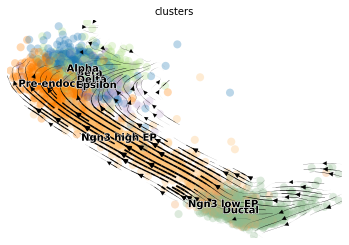

In [ ]:
X2, flows2, labels2, n_pcs  = pancreas_rnavelo_pcs()

In [ ]:
print(X.shape)
print(flows.shape)
print(len(labels))

print(X2.shape)
print(flows2.shape)
print(len(labels2))
print(n_pcs)

(3696, 27998)
(3696, 27998)
(3696,)
(3696, 50)
(3696, 50)
(3696,)


## scvelo Dentategyrus dataset

In [ ]:
#export

def d_rnavelo_load_data():
    # load data
    adata = scv.datasets.dentategyrus()
    
    #preprocess data and calculate rna velocity
    scv.pp.filter_and_normalize(adata)
    scv.pp.moments(adata)
    scv.tl.velocity(adata, mode='stochastic')
    
    return adata

def d_rnavelo():
    # load preprocessed data
    adata = d_rnavelo_load_data()
    
    # set datapoints (X) and flows
    X = torch.tensor(adata.X.todense())
    flows = torch.tensor(adata.layers["velocity"])
    labels = add_labels(adata.obs["clusters"])
        
    return X, flows, labels

def d_rnavelo_pcs():
    adata = d_rnavelo_load_data()
    
    # calculate velocity pca (50 dimensions) and display pca plot (2 dimensions)
    scv.tl.velocity_graph(adata)
    scv.pl.velocity_embedding_stream(adata, basis='pca')
    
    X = torch.tensor(adata.obsm["X_pca"])
    flows = torch.tensor(adata.obsm["velocity_pca"])
    labels = add_labels(adata.obs["clusters"])
    
    return X, flows, labels, n_pcs

Normalized count data: X, spliced, unspliced.
Logarithmized X.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:04) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:07) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/36 cores)


  0%|          | 0/2930 [00:00<?, ?cells/s]

    finished (0:00:26) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:01) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)


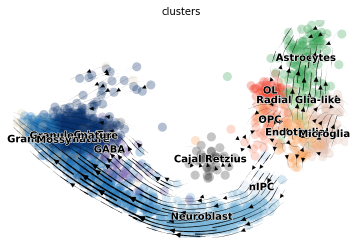

In [ ]:
X, flows, labels = d_rnavelo_50pcs()